In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
%matplotlib inline

temp = ctrl.Antecedent(np.arange(20, 35, 1), 'Temperature')
demand = ctrl.Antecedent(np.arange(3500, 7000, 1), 'Demand')
price = ctrl.Consequent(np.arange(10, 60), 'Price')

temp['low'] = fuzz.trimf(temp.universe, [20, 20, 27])
temp['medium'] = fuzz.trimf(temp.universe, [23, 27, 31])
temp['high'] = fuzz.trimf(temp.universe, [27, 35, 35])

demand['low'] = fuzz.trimf(demand.universe, [3500, 3500, 5250])
demand['medium'] = fuzz.trimf(demand.universe, [4500, 5250, 6000])
demand['high'] = fuzz.trimf(demand.universe, [5250, 7000, 7000])

price['low'] = fuzz.trimf(price.universe, [10, 10, 35])
price['medium'] = fuzz.trimf(price.universe, [20, 35, 50])
price['high'] = fuzz.trimf(price.universe, [35, 60, 60])

In [57]:
training_df = pd.read_csv("datasets/cleaned_training.csv")
testing_df = pd.read_csv("datasets/cleaned_testing.csv")

In [122]:
# Fuzzy membership functions
temp_low = fuzz.trimf(temp.universe, [20, 20, 27])
temp_mid = fuzz.trimf(temp.universe, [23, 27, 31])
temp_high = fuzz.trimf(temp.universe, [27, 35, 35])

demand_low = fuzz.trimf(demand.universe, [3500, 3500, 5250])
demand_mid = fuzz.trimf(demand.universe, [4500, 5250, 6000])
demand_high = fuzz.trimf(demand.universe, [5250, 7000, 7000])

price_low = fuzz.trimf(price.universe, [10, 10, 35])
price_mid = fuzz.trimf(price.universe, [20, 35, 50])
price_high = fuzz.trimf(price.universe, [35, 60, 60])

# Values to pass through
temp_vals = training_df['T(t-2)'].values
demand_vals = training_df['D(t)'].values
price_vals = training_df['P(t+1)'].values


def degree_of_support(universes, memberships, values):
    N = len(values[0])
    support = 0
    
    for i in range(N):
        x = fuzz.interp_membership(universes[0], memberships[0], values[0][i])
        y = fuzz.interp_membership(universes[1], memberships[1], values[1][i])
        z = fuzz.interp_membership(universes[2], memberships[2], values[2][i])
        
        support = support + (x * y * z)
    
    return support / N


universes = [temp.universe, demand.universe, price.universe]
values = [temp_vals, demand_vals, price_vals]
memberships = [temp_high, demand_high, price_high]


0.002583958654827969


In [134]:
# Calculate degree of confidence of each rule

def degree_of_confidence(universes, memberships, values):
    N = len(values[0])
    temp = 0
    
    for i in range(N):
        x1 = fuzz.interp_membership(universes[0], memberships[0], values[0][i])
        x2 = fuzz.interp_membership(universes[1], memberships[1], values[1][i])
        
        temp = temp + (x1 * x2)
    
    
    return degree_of_support(universes, memberships, values) / (temp / N)

universes = [temp.universe, demand.universe, price.universe]
values = [temp_vals, demand_vals, price_vals]
memberships = [temp_high, demand_high, price_mid]

print(degree_of_confidence(universes, memberships, values))

0.6307061343824586


The Average Relative Error Value is 0.276344065915


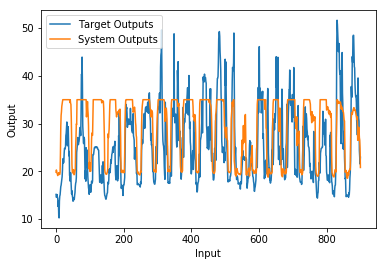

In [135]:
r1 = ctrl.Rule(temp['low'] & demand['low'], price['low'])
r2 = ctrl.Rule(temp['low'] & demand['medium'], price['low'])
r3 = ctrl.Rule(temp['low'] & demand['low'], price['low'])

r4 = ctrl.Rule(temp['medium'] & demand['low'], price['low'])
r5 = ctrl.Rule(temp['medium'] & demand['medium'], price['medium'])
r6 = ctrl.Rule(temp['medium'] & demand['high'], price['medium'])

r7 = ctrl.Rule(temp['high'] & demand['low'], price['low'])
r8 = ctrl.Rule(temp['high'] & demand['medium'], price['medium'])
r9 = ctrl.Rule(temp['high'] & demand['high'], price['medium'])

pricing_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9,])

pricing = ctrl.ControlSystemSimulation(pricing_ctrl)

Temperature = training_df['T(t-2)'].values
Demand = training_df['D(t)'].values
length = len(training_df['D(t)'])
SystemOutputs = np.zeros(length)

for i in range(length):
    pricing.input['Temperature'] = Temperature[i]
    pricing.input['Demand'] = Demand[i]
    pricing.compute()
    SystemOutputs[i] = pricing.output['Price']
    
TargetOutputs = np.array(training_df['P(t+1)'].values)

RErr = np.sum(np.absolute(TargetOutputs - SystemOutputs)
              /np.absolute(TargetOutputs))/length

print('The Average Relative Error Value is', RErr)

input = np.arange(901)
plt.plot(input, TargetOutputs)
plt.plot(input, SystemOutputs)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('')
plt.legend(['Target Outputs', 'System Outputs'])
plt.show()